First, we will create the basic VPython background in order to animate the molecular movements, as well as importing all the required methods for our program.

In [100]:
from vpython import *
from numpy import zeros, arange, sqrt, array, linspace, random, pi, exp
from random import random
from pylab import savefig, hist, xlabel, ylabel, title, plot, show, legend, ylim
import matplotlib.pyplot as plt

#================================================================================
# Scene set up
#================================================================================
w = 50  # box width
scene = canvas(width = 10*w, height = 10*w, center = vector(w/2, w/2, 0), 
               range = 0.6*w, fov = 0.01, userzoom = False, autoscale = False, 
               userspin = False)
# box
box(pos=vector(0,w/2,0), size=vector(1,w,1), color=color.red)
box(pos=vector(w,w/2,0), size=vector(1,w,1), color=color.red)
box(pos=vector(w/2,w,0), size=vector(w,1,1), color=color.red)
box(pos=vector(w/2,0,0), size=vector(w,1,1), color=color.red)


<IPython.core.display.Javascript object>

In this next section, I re-used the force function from the Molecular Dynamics lecture that computes the force each collision (either with the wall or with another molecule) impacts on the particle. 

In this function, I examined the Leonard-Jones potential from Van der Waals interactions between the molecules using the equation 
    U = 4*epsilon*((delta/r)^12 - (delta/r)^6)

In [101]:
#================================================================================
# Compute forces, potential energy and radial distribution function
#================================================================================

def force(x,y,rdf):
    
    Fx = zeros(N, float)                           # x component of net force on each atom
    Fy = zeros(N, float)                           # y component of net force on each atom
    func = rdf[:]                                  # radial distribution function
    U = 0                                          # reinitialize total potential energy
    Fwall = 0                                      # reinitialize total force on walls    
    for i in range(N):

        # collision with walls
        if x[i] < 0.5:                             # deals with collision with left wall
            Fx[i] += k*(0.5 - x[i])
            Fwall += abs(k*(0.5 - x[i]))
            U += 0.5*k*(0.5 - x[i])*(0.5 - x[i])
        elif x[i] > (w - 0.5):                     # deals with collision with right wall
            Fx[i] += k*(w - 0.5 - x[i])
            Fwall += abs(k*(w - 0.5-x[i]))
            U += 0.5*k*(w - 0.5 - x[i])*(w - 0.5 - x[i])
        if y[i] < 0.5:                             # deals with collision with upper wall
            Fy[i] += k*(0.5 - y[i])
            Fwall += abs(k*(0.5 - y[i]))
            U += k*(0.5 - y[i])*(0.5 - y[i])
        elif y[i] > (w - 0.5):                     # deals with collision with lower wall
            Fy[i] += k*(w - 0.5 - y[i])
            Fwall += abs(k*(w - 0.5 - y[i]))
            U += k*(w - 0.5 - y[i])*(w - 0.5 - y[i])
        
        # Lennard-Jones interaction: for each molecule, calculate the net forces from all LJ potential interactions
        for j in range(i+1, N):
            deltax = x[j] - x[i]
            deltay = y[j] - y[i]
            Rij = sqrt(deltax*deltax + deltay*deltay)
            
            # radial distribution function
            nbin = int(Rij/dr)
            if nbin == 0:
                func[nbin] = 0
            else:
                func[nbin] += 1/(2*pi*nbin*dr)

            # if atoms within cutoff, compute LJ force
            if Rij <= cutoff:
               
                # potential energy
                U += sigmaTwelfth/Rij**12 - sigmaSixth/Rij**6                    # Van der Waals interaction

                # force
                Fijx = (-12*ljTwelfth/Rij**14 + 6*ljSixth/Rij**8)*(x[j] - x[i])  # Van der Waals interaction
                Fijy = (-12*ljTwelfth/Rij**14 + 6*ljSixth/Rij**8)*(y[j] - y[i])  # Van der Waals interaction
            
                # update net forces
                Fx[i] += Fijx
                Fy[i] += Fijy
                Fx[j] += -Fijx
                Fy[j] += -Fijy
    
    return Fx, Fy, 4*epsilon*U, func

#================================================================================
# Normalize radial distribution function
#================================================================================

def normalize(rdf):
    
    func = rdf[:]
    # normalize function using Trapezoid Rule
    integral = 0.5*dr*(func[0] + 2*sum(func[0:numbin-2]) + func[numbin-1])
    
    return func*w**2/(N*integral)

Here is an added portion to the original Molecular Dynamics lecture.

In this piece of program, I implemented the Maxwell-Boltzmann distribution using the probability distribution equation, utilizing other constant values such as the Avogadro's number, mass of one helium atom, Boltzmann constant, and temperature of ideal gas.

In [102]:
#================================================================================
# Analytical Maxwell-Boltzmann distribution equation
#================================================================================

def vdistribution(v):
    return sqrt(2/pi) * (m/(kb*T))**(3/2) * v**2 * exp(-m*v**2/(2*kb*T))

# constants to use to plot MB distribution
avogadro = 6.0221408e23                             # number of atoms in one mole of helium gas
m = 0.004/avogadro                                  # mass of one helium atom in kg
kb = 1.380649e-23                                   # Boltzmann constant in J/K
T = 273.15                                          # temperature of ideal gas in Kelvin
MBvelocity = linspace(0, 4000, 2000)                # linspace of velocities
problist = vdistribution(MBvelocity)                # list that stores distribution of velocities

Next, we will add some parameter values useful for the simulation as well as calculating particle speed in the next portion, which is what this project attempts to calculate and analyze.

In [103]:
#================================================================================
# Simulation parameters
#================================================================================
N = 80                                              # number of atoms
dt = 0.02                                           # timestep
m = 1.0                                             # mass
sigma = 3                                           # LJ radius
sigmaSixth = sigma**6                               # sigma^6
sigmaTwelfth = sigmaSixth**2                        # sigma^12
epsilon = 1.0                                       # LJ well depth
ljSixth = 4*epsilon*sigmaSixth                      # 4*epsilon*sigma**6
ljTwelfth = 4*epsilon*sigmaTwelfth                  # 4*epsilon*sigma**12
k = 50                                              # stiffness of the walls
T1 = 1.0                                            # setpoint temperature 1
T2 = 2.5                                            # setpoint temperature 2
T3 = 10.0                                           # setpoint temperature 3
nstemp = 50                                         # number of time steps before velocity rescaling
nsgraph = 1000                                      # number of time steps before graph output and rdf normalization
cutoff = 3*sigma                                    # cutoff distance for force calculation
    

Initializing arrays, radial distribution function, and other factors associated with the VPython simulation to prepare for the main simulation loop. Specifically, here is where we introduce the initial positions of the atoms and their initial velocities in the x and y directions––determined by the random() function.

In [104]:
#================================================================================
# Initialization
#================================================================================

# arrays for position, velocity, and time
x = zeros(N, float)
y = zeros(N, float)  
vx = array([0.5 - random() for i in range(N)], float)
vy = array([0.5 - random() for i in range(N)], float)
vxmid = zeros(N,float)
vymid = zeros(N,float)

# radial distribution function
dr = 0.1*sigma                                      # bin width
numbin = 2*int(w/dr)                                # number of bins
rdf = zeros(numbin, float)                          # initialize to zeros
rbins = arange(0,dr*numbin,dr)                      # r values for each bin
       
# atoms
ball = []

# initial atom spacing
dx = w/(int(sqrt(N)) + 1)
dy = w/(int(sqrt(N)) + 1)
x0 = 0.5*dx
y0 = 0.5*dy

# initialize positions of atoms
for i in range(N):
    x[i] = x0
    y[i] = y0
    ball.append(sphere(pos=vector(x0,y0,0), radius = sigma*2**(1/6)/2, color=color.white))
    x0 += dx
    if x0 > w:
        x0 = 0.5*dx
        y0 += dy

t = 0                                               # Initialize time
counter = 0                                         # Initialize number of time steps

# Perform a half step for Verlet Algorithm
Fx,Fy,U, rdf = force(x,y,rdf)
vxmid = vx + 0.5*dt*Fx/m
vymid = vy + 0.5*dt*Fy/m
K = 0.5*m*sum(vx**2 + vy**2)
T = K/N    

In [105]:
#================================================================================
# Output
#================================================================================

# Radial distribution function graph
g1 = graph(width=400, height=250, xtitle="Distance (sigma)", ytitle="g(r)", xmin=0, xmax = w/sigma)
radialdistplot = gcurve(graph = g1, color=color.green)
for i in range(numbin):
    radialdistplot.plot(i*dr/sigma, rdf[i])


This is arguably the most important part of this project: where we use Verlet algorithm to compute the velocity change for each of the 80 gas molecules as time goes on and plot this data in the form of a histogram to compare with the Maxwell-Boltzmann distribution curve.

In addition, this is also where we implements the two types of thermostats that we are going to compare: Isokinetic thermostat and Berendsen thermostat. We will run this simulation loop a couple of time with different parameters like initial temperature and different thermostat to see how well our simulation fits with the Maxwell-Boltzmann distribution.

In [106]:
#================================================================================        
# Main simulation loop
#================================================================================

trange = arange(0, 1500, 1)                 # regulates a time constraint for the simulation
thermostat_option = 2                       # 1: Isokinetic thermostat, 2: Berendsen thermostat

for a in trange:
    
    rate(5/dt)
    
    # Verlet algorithm
    x += vxmid*dt
    y += vymid*dt
    Fx, Fy, U, rdf = force(x,y,rdf)         # calculate forces and potential energy using force() function
    vx = vxmid + 0.5*Fx/m*dt
    vy = vymid + 0.5*Fy/m*dt
    vxmid += Fx/m*dt
    vymid += Fy/m*dt
    K = 0.5*m*sum(vx*vx + vy*vy)            # updates current kinetic energy
    T = K/N                                 # update current temperature that's related to the kinetic energy
    
    # Create histogram to represent velocity data at some time stops
    velocity = zeros(N, float)              # velocity array initialized to store information for the 80 particles
    BINS = arange(0, 10, 0.1)               # number of bins in the histogram
    for i in range(N):
        velocity[i] = sqrt(vx[i]**2 + vy[i]**2)   
    
    # Create a new histogram every 25 iterations to observe the speed distribution change
    if (a % 25 == 0):
        histogram = hist(velocity, bins = BINS, range = (0, 10), color = "r")
        title("Speed Distribution of Molecules")
        xlabel("Speed")
        ylabel("Number of Molecules")
        ylim(0, 10)                         # make sure that our graph always has the same size
        savefig("plot(%d).png" % a)         # use the figures saved to create .gif
        plt.gcf().clear()                   # clear the histogram created after we save it to prepare for next plotting
        

    # Update atom positions
    for i in range(N):
        ball[i].pos = vector(x[i], y[i], 0)
        
    if counter % nsgraph == 0:
        rdf = normalize(rdf)                # normalize radial distribution function
        radialdistplot.delete()             # plot radial distribution function
        for i in range(numbin):
            radialdistplot.plot(i*dr/sigma, rdf[i])
        rdf = zeros(numbin, float)          # reinitialize radial distribution function  
        
    # Thermostat to regularize the temperature to scale the velocities
    if counter % nstemp == 0 and counter > 0:
        if T == 0:
            for i in range(N):
                vxmid[i] = 1.0 - random()
                vymid[i] = 1.0 - random()
        else:
            if thermostat_option == 1:
                gamma = sqrt(T1/T)                   # Isokinetic thermostat
            else:
                gamma = sqrt(1+dt*(T/T1 - 1)/10)     # Berendsen thermostat
            vxmid *= gamma
            vymid *= gamma     
       
    counter += 1                            # number of timesteps
    t += dt                                 # increase time  

<Figure size 432x288 with 0 Axes>

Lastly, here is where we will plot the Maxwell-Boltzmann distribution curve according to the precise formula for it and with the parameters we prepared in the above steps. We will be comparing this curve with the distributions we see from the simulation loop.

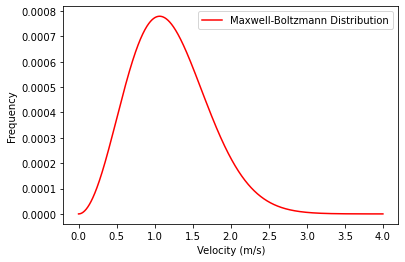

In [107]:
#================================================================================        
# Plotting analytical Maxwell-Boltzmann Distribution Curve
#================================================================================

plot(MBvelocity/1000, problist, "r-", label = "Maxwell-Boltzmann Distribution")
xlabel("Velocity (m/s)")
ylabel("Frequency")
legend()
show()